In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats as scs

In [2]:
!whoami
!date

ndbs
Thu Feb  6 14:38:16 PST 2020


## Goal: Find a probability distribution with mean 2 and an "uncertainty interval" of 1.5 to 5

### We need such a distribution for modeling uncertainty in the estimates of a relative risk for the BEP simulation

The challenge here is that the mean is skewed heavily towards the left uncertainty bound, which requires a highly skewed distribution.

We started with a [triangular distribution](https://en.wikipedia.org/wiki/Triangular_distribution) supported on $[1.5,5]$ with mode $2$. Then Ali realized that the mean of this distribution is too high. In fact, the mean is $\frac{1.5+2+5}{3} = 2.833$, not $2$, and moreover since the mean of a triangular distribution is $\frac{a+b+c}{3}$ (where $a,b,c$ are the left and right endpoints and mode), *there is no triangular distribution on $[1.5,5]$ with mean $2$* (the minimum possible mean is $(1.5+1.5+5)/{3} = 2.667$).

Abie then suggested trying a [PERT distribution](https://en.wikipedia.org/wiki/PERT_distribution) supported on $[1.5,5]$. A standard PERT distribution (with weighting factor 4) on this interval *also* cannot have mean equal to $2$, but a **modified-PERT distribution** can. The modified-PERT distribution is just a shifted and scaled [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), but parameterized differently (in terms of the mode and a weighting factor determining the location of the mean relative to the mode, instead of the standard parameterization using the exponents $\alpha$ and $\beta$).

We ended up using a shifted [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) with shape parameter $\alpha=2$ in the actual BEP simulation.

In [3]:
(1.5+2+5)/3

2.8333333333333335

In [4]:
8/3

2.6666666666666665

## Try Beta distributions

This part doesn't quite work - there's an error in my attempts at scaling and shifting. But I figured out a way to fix it in the final section below!

Function from James for converting mean and variance into parameters for Beta:

In [5]:
def a_b_from_mean_var(mean, variance):
    if mean <= 0 or mean >= 1:
        raise ValueError("Mean must be in the interval (0,1)")
    if variance >= mean*(1-mean):
        raise ValueError("Variance too large")
        
    a = mean*(mean*(1-mean)/variance - 1)
    b = (1-mean)*(mean*(1-mean)/variance - 1)
    return a, b

In [6]:
.2*(1-.2)

0.16000000000000003

In [7]:
mean, variance = .2, 0.02
a, b = a_b_from_mean_var(mean, variance)

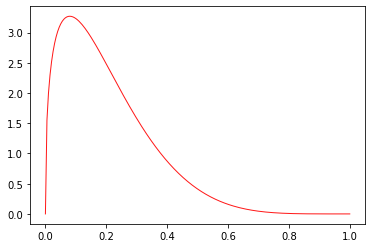

In [8]:
fig, ax = plt.subplots(1,1)

x = np.linspace(0, 1, 200)
# x = np.linspace(loc_left, loc_left+scale, 200)
# x = np.linspace(scs.beta.ppf(0.01, a, b), scs.beta.ppf(0.99, a, b), 100)
ax.plot(x, scs.beta.pdf(x, a, b), 'r-', lw=1, alpha=0.9, label='beta pdf')

plt.show()

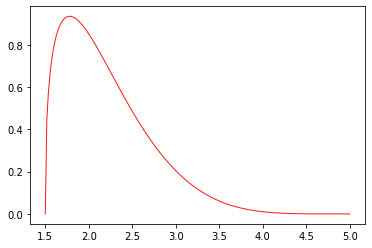

In [9]:
loc_left, scale = 1.5, 5-1.5

fig, ax = plt.subplots(1,1)

x = np.linspace(loc_left, loc_left+scale, 200)
# x = np.linspace(loc_left, loc_left+scale, 200)
# x = np.linspace(scs.beta.ppf(0.01, a, b), scs.beta.ppf(0.99, a, b), 100)
ax.plot(x, scs.beta.pdf(x, a, b, loc_left, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')

plt.show()

In [10]:
print((mean*scale+loc_left), variance*scale**2)

2.2 0.245


In [11]:
print((2.2-loc_left)/scale, 0.245/scale**2)

0.20000000000000004 0.02


In [12]:
def get_standardized_mean_var(mean, variance, loc, scale):
    return (mean-loc)/scale, variance/scale**2

def get_transformed_mean_var(mean, variance, loc, scale):
    return (mean*scale+loc), variance*scale**2

In [13]:
loc, scale = 1.5, 5-1.5
mean, variance = 2, 0.1*scale**2
get_standardized_mean_var(mean, variance, loc, scale)

(0.14285714285714285, 0.1)

In [14]:
0.14285714285714285*(1-0.14285714285714285)

0.12244897959183673

In [15]:
std_mean, std_variance = get_standardized_mean_var(mean, variance, loc, scale)
a, b = a_b_from_mean_var(std_mean, std_variance)
print(a,b)

0.03206997084548102 0.19241982507288616


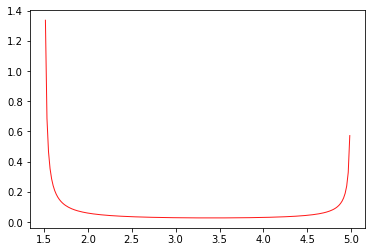

In [16]:
fig, ax = plt.subplots(1,1)

x = np.linspace(loc, loc+scale, 200)
ax.plot(x, scs.beta.pdf(x, a, b, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')

plt.show()

In [17]:
5-1.5

3.5

## Try a Gamma distribution

SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

Wikipedia: https://en.wikipedia.org/wiki/Gamma_distribution

### We ended up using a Gamma distribution with shape parameter $\alpha=2$ for the relative risk in the BEP model.

The Gamma distribution assigns very little probability near the right extreme of 5.

Note that as $\alpha$ increases, the distribution looks more and more like a normal distribution concentrated at $2$. When $\alpha=1$, this is a shifted exponential distribution with maximum at the left endpoint $x=1.5$. When $0<\alpha<1$, the density has an asymptote at $x=1.5$.

In [18]:
import scipy.stats

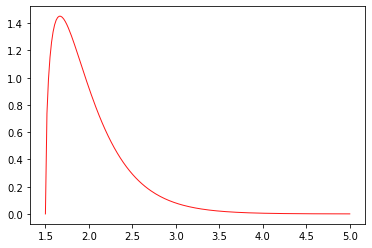

In [19]:
mean = 2 # desired mean of shifted Gamma distribution
loc = 1.5 # location paramter is the left endpoint of the shifted distribution's support
width = 5 - loc # upper bound - lower bound (= 3.5 if loc = 1.5)
std_mean = mean - loc # "standardized" mean, of the un-shifted distribution
a = 1.5 # shape parameter
scale = std_mean/a # mean of standard Gamma is std_mean=shape*scale, so scale = std_mean/shape

fig, ax = plt.subplots(1,1)

x = np.linspace(loc, loc+width, 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='gamma pdf')

plt.show()

In [20]:
print(scipy.stats.gamma.cdf(5, a, loc, scale),
      scipy.stats.gamma.sf(5, a, loc, scale),
      scipy.stats.gamma.sf(3, a, loc, scale),
      scipy.stats.gamma.stats(a, loc=loc, scale=scale, moments='mvsk'))

0.9998947238182285 0.00010527618177149762 0.02929088653488826 (array(2.), array(0.16666667), array(1.63299316), array(4.))


## Try a lognormal distribution

SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html

Wikipedia: https://en.wikipedia.org/wiki/Log-normal_distribution

The lognormal distribution assigns slightly more probability near the right extreme of 5. It achieves this by concentrating more probability near the left extreme of 1.5 as well, and the variance is correspondingly higher than for the Gamma distribution.

As the shape parameter $\sigma\to\infty$, the mode of the lognormal distribution approaches the left endpoint $x=1.5$; this is similar to letting $\alpha\to 0$ for the Gamma distribution. As the shape parameter $\sigma\to 0$, the distribution becomes more symmetric and concentrated around $x=2$; this is similar to letting $\alpha\to\infty$ for the Gamma distribution.

**Question:** As $\sigma\to 0$, does the shape of the lognormal distribution approach the shape of a normal distribution near $x=2$?

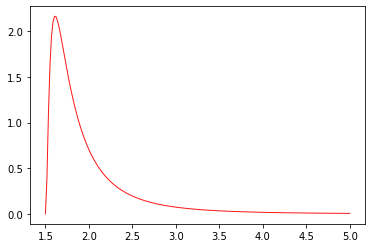

In [21]:
mean = 2 # desired mean of shifted lognormal distribution
loc = 1.5 # location paramter is the left endpoint of the shifted distribution's support
width = 5 - loc # upper bound - lower bound (= 3.5 if loc = 1.5)
std_mean = mean - loc # "standardized" mean, of the un-shifted distribution

s = 1 # shape parameter s = sigma = std dev of corresponding normal distribution
mu = np.log(std_mean) - s**2/2 # mu = mean of corresponding normal distribution
scale = np.exp(mu) # scale parameter is e^mu

fig, ax = plt.subplots(1,1)

x = np.linspace(loc, loc+width, 200)
ax.plot(x, scipy.stats.lognorm.pdf(x, s, loc, scale), 'r-', lw=1, alpha=0.9, label='lognormal pdf')

plt.show()

In [22]:
print(scipy.stats.lognorm.cdf(5, s, loc, scale),
      scipy.stats.lognorm.sf(5, s, loc, scale),
      scipy.stats.lognorm.sf(3, s, loc, scale),
      scipy.stats.lognorm.stats(s, loc=loc, scale=scale, moments='mvsk'))

0.99277564983306 0.007224350166940017 0.054953388759836776 (array(2.), array(0.42957046), array(6.18487714), array(110.93639218))


## Try a Beta distribuiton again

SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html

Wikipedia: https://en.wikipedia.org/wiki/Beta_distribution

The Beta distribution assigns even less probability near 5 than Gamma, and has a correspondingly wider bulge around its mode, with a slightly larger variance.

Note that choosing the same $\alpha$ for the Gamma and Beta distributions will make the distributions look the same at their left endpoints.

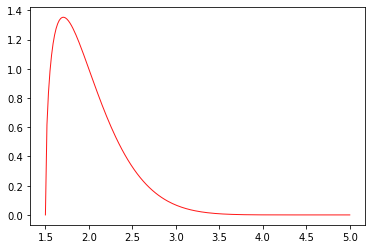

In [23]:
mean = 2 # desired mean of shifted and scaled Beta distribution
loc = 1.5 # location paramter is the left endpoint of the shifted distribution's support
width = 5 - loc # upper bound - lower bound (= 3.5 if loc = 1.5)
std_mean = (mean - loc)/width # "standardized" mean - of the un-shifted, un-scaled Beta distribution

a = 1.5 # shape parameter a=alpha
b = (1/std_mean - 1)*a # mean of Beta is mean = a/(a+b), so we can compute b=beta from mean and a=alpha
scale = width # scale the Beta distribution by the width of the interval

fig, ax = plt.subplots(1,1)

x = np.linspace(loc, loc+width, 200)
ax.plot(x, scipy.stats.beta.pdf(x, a, b, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')

plt.show()

In [24]:
print(scipy.stats.beta.cdf(4.5, a, b, loc, scale),
      scipy.stats.beta.sf(4.5, a, b, loc, scale),
      scipy.stats.beta.sf(3, a, b, loc, scale),
      scipy.stats.beta.stats(a, b, loc=loc, scale=scale, moments='mvsk'))

0.9999999184825924 8.15174076018721e-08 0.01593308747109201 (array(2.), array(0.13043478), array(1.10754985), array(1.25925926))
